In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
import os
import geopandas as gpd
import contextily as ctx
from dataclasses import dataclass
import numpy as np
from scipy.integrate import odeint
from IPython.core.getipython import get_ipython

notebook_path = os.path.join(os.getcwd(), get_ipython().starting_dir)
current_dir = os.path.dirname(notebook_path)

CLEANED_DATA_PATH = os.path.join(current_dir, 'data/processed/cleaned_data.csv')
SHAPERAW_DATA_PATH = os.path.join(current_dir, 'data/processed/shapefile/shapefile.shp')


pd.read_csv(CLEANED_DATA_PATH).head()

,Zip Code,Number of Households,Number of Families,Number of Families with Children,Number of Families with NO Children,Families with no Earners,Percent Distribution of Families,Percent Distribution of Families with Children,Percent Distribution of Families with NO Children,Median Income of all Households,Median Income of all Families,ZCTA5CE10,latitude,longitude
0,10001,14273,4256,1543,2713,329,4256,36.3,63.7,101409,142042.0,10001,40.750634,-73.997176
1,10002,34737,16914,4650,12264,5433,16914,27.5,72.5,37093,38815.0,10002,40.715777,-73.986207
2,10003,25181,6855,2057,4798,786,6855,30.0,70.0,137533,219957.0,10003,40.731829,-73.989181
3,10004,2113,1062,605,457,37,1062,57.0,43.0,216017,247237.0,10004,40.694170,-74.015954
4,10005,4782,1311,635,676,0,1311,48.4,51.6,197188,250000.0,10005,40.706004,-74.008785


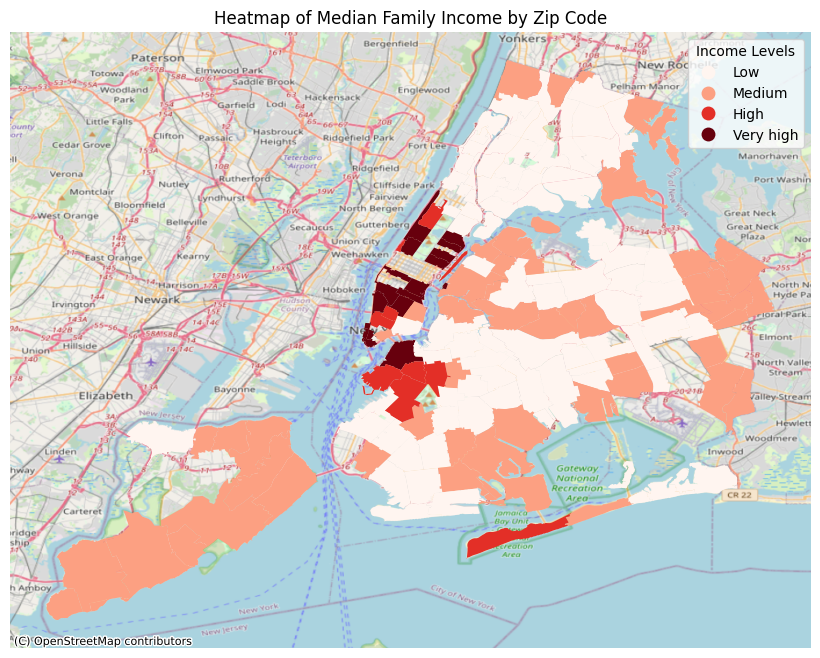

In [2]:
import geopandas as gpd
SHAPERAW_DATA_PATH = '/Users/alejandrodiaz/Documents/GitHub/DS_Project/data/raw/Modified Zip Code Tabulation Areas (MODZCTA)/geo_export_152003af-efec-4038-9b6f-1963116a24c2.shp'
gdf = gpd.read_file(SHAPERAW_DATA_PATH)

data = pd.read_csv(CLEANED_DATA_PATH)

gdf['zcta'] = gdf['zcta'].astype(str)
data['Zip Code'] = data['Zip Code'].astype(str)
merged = gdf.merge(data, left_on='zcta', right_on='Zip Code')
merged['Median Income of all Families'] = pd.to_numeric(merged['Median Income of all Families'], errors='coerce')
merged['Median Income of all Families'].fillna(merged['Median Income of all Families'].median(), inplace=True)
merged['Income Level'] = pd.cut(merged['Median Income of all Families'], bins=4, labels=["Low", "Medium", "High", "Very high"])

# Plot the merged data
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
merged.plot(column='Income Level', ax=ax, legend=True, cmap='Reds', categorical=True)
leg = ax.get_legend()
leg.set_title('Income Levels')
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=merged.crs.to_string())
ax.set_axis_off()
plt.title('Heatmap of Median Family Income by Zip Code')
plt.show()

Total households: 3532126


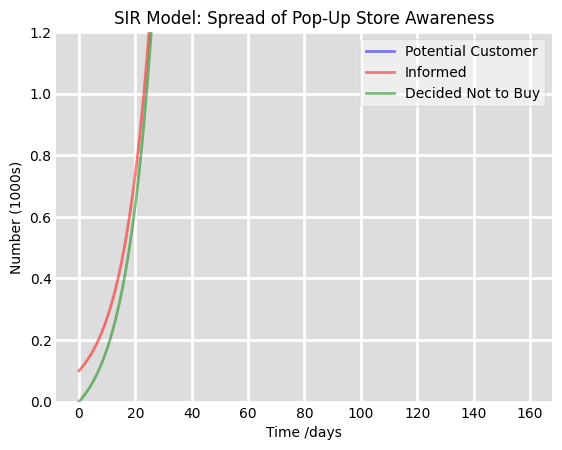

In [3]:
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import pandas as pd

# Load the CSV file
csv_file_path = '/Users/alejandrodiaz/Documents/GitHub/DS_Project/data/processed/cleaned_data.csv'
data = pd.read_csv(csv_file_path)

# Calculate the total number of households
total_households = data['Number of Households'].sum()
print(f'Total households: {total_households}')

# Function to compute the derivatives for the SIR model
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

@dataclass
class SIRDiagram:
    # Initialize with the total number of households
    n: int = total_households
    # Assume initial number of 'infected' (people aware of the pop-up)
    i: int = 100  # This is an example value, adjust based on your initial marketing data
    r: int = 0
    beta: float = 0.2  # Adjust based on expected contact rate
    gamma: float = 1.0 / 10  # Adjust based on expected recovery rate
    steps: int = 160

    def s(self) -> int:
        return self.n - self.i - self.r

    def plot(self):
        t = np.linspace(0, self.steps, self.steps)
        y0 = self.s(), self.i, self.r
        N, beta, gamma = self.n, self.beta, self.gamma
        ret = odeint(deriv, y0, t, args=(N, beta, gamma))
        S, I, R = ret.T

        fig = plt.figure(facecolor="w")
        ax = fig.add_subplot(111, facecolor="#dddddd", axisbelow=True)
        ax.plot(t, S / 1000, "b", alpha=0.5, lw=2, label="Potential Customer")
        ax.plot(t, I / 1000, "r", alpha=0.5, lw=2, label="Informed")
        ax.plot(t, R / 1000, "g", alpha=0.5, lw=2, label="Decided Not to Buy")

        ax.set_xlabel("Time /days")
        ax.set_ylabel("Number (1000s)")
        ax.set_ylim(0, 1.2)
        ax.yaxis.set_tick_params(length=0)
        ax.xaxis.set_tick_params(length=0)
        ax.grid(which="major", c="w", lw=2, ls="-")
        legend = ax.legend()
        legend.get_frame().set_alpha(0.5)
        for spine in ("top", "right", "bottom", "left"):
            ax.spines[spine].set_visible(False)

        plt.title("SIR Model: Spread of Pop-Up Store Awareness")
        plt.show()

def main():
    diagram = SIRDiagram()
    diagram.plot()

if __name__ == "__main__":
    main()


In [4]:
"""
This script reads a CSV file and prints the second column.
"""

import pandas as pd

RAW_DATA_PATH = '/Users/alejandrodiaz/Documents/GitHub/DS_Project/data/raw/ACSST5Y2021.S1903_2023-11-14T204901/data.csv'
META_DATA_PATH = '/Users/alejandrodiaz/Documents/GitHub/DS_Project/data/raw/ACSST5Y2021.S1903_2023-11-14T204901/metadata.csv'
metadf = pd.read_csv(META_DATA_PATH)
print(metadf.columns)

df = pd.read_csv(RAW_DATA_PATH)
print(df.columns) 

#ok to the Column name in Metadata is in Data, the label is what the codes mean, lets rename the columns



Index(['Column Name', 'Label'], dtype='object')
Index(['GEO_ID', 'NAME', 'S1903_C01_001E', 'S1903_C01_001EA', 'S1903_C01_001M',
       'S1903_C01_001MA', 'S1903_C01_002E', 'S1903_C01_002M',
       'S1903_C01_002MA', 'S1903_C01_002EA',
       ...
       'S1903_C03_038MA', 'S1903_C03_039E', 'S1903_C03_039EA',
       'S1903_C03_039M', 'S1903_C03_039MA', 'S1903_C03_040E',
       'S1903_C03_040EA', 'S1903_C03_040M', 'S1903_C03_040MA', 'Unnamed: 482'],
      dtype='object', length=483)


/Users/alejandrodiaz/Documents/GitHub/DS_Project/venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alejandrodiaz/Documents/GitHub/DS_Project/venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alejandrodiaz/Documents/GitHub/DS_Project/venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alejandrodiaz/Documents/GitHub/DS_Project/venv/l

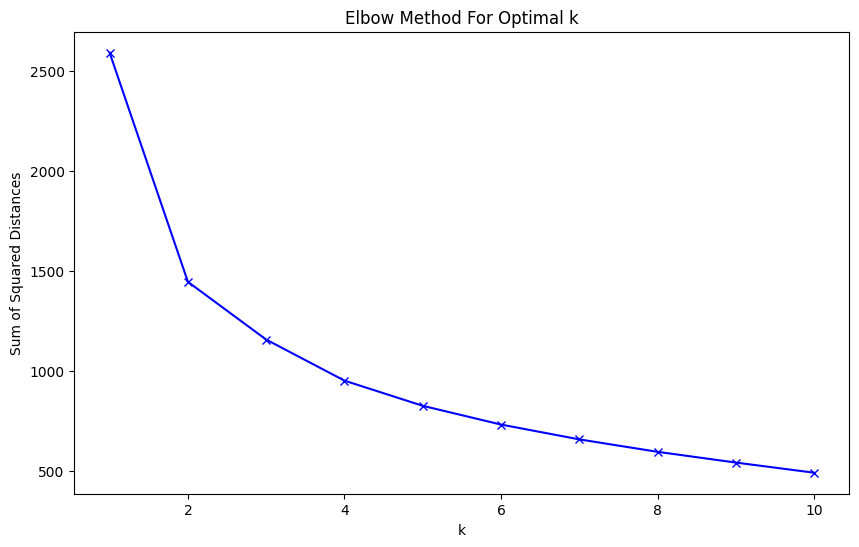

/Users/alejandrodiaz/Documents/GitHub/DS_Project/venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


         Number of Households  Number of Families  \
Cluster                                             
0                16900.116279         9798.441860   
1                 3851.305882         2172.423529   
2                 6769.540541         4151.648649   
3                29429.058824        18906.294118   

         Number of Families with Children  \
Cluster                                     
0                             3755.034884   
1                              755.741176   
2                             1902.594595   
3                             8101.568627   

         Number of Families with NO Children  Families with no Earners  \
Cluster                                                                  
0                                6043.406977               1176.127907   
1                                1416.682353                272.470588   
2                                2249.054054                453.621622   
3                               10804.72

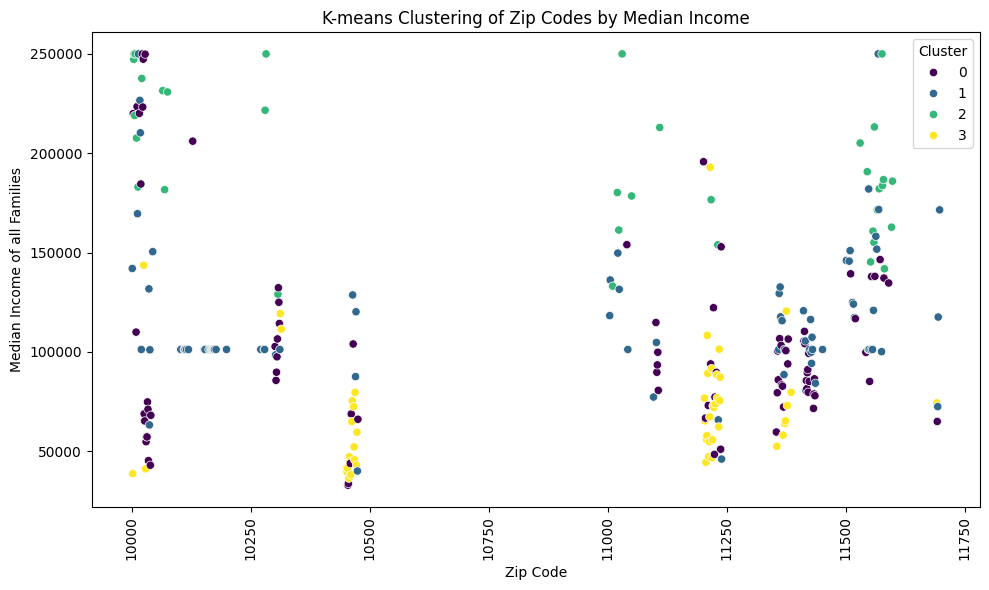

In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# Specify the actual directory path to your data
data_path = '/Users/alejandrodiaz/Documents/GitHub/DS_Project/data/processed/cleaned_data.csv'  # Update this to the correct path

# Step 0: Read the data into a pandas DataFrame
data = pd.read_csv(data_path)

# Step 1: Convert columns to numeric and handle missing values
numeric_cols = ['Number of Households', 'Number of Families', 
                'Number of Families with Children', 'Number of Families with NO Children', 
                'Families with no Earners', 'Percent Distribution of Families', 
                'Percent Distribution of Families with Children', 
                'Percent Distribution of Families with NO Children', 
                'Median Income of all Households', 'Median Income of all Families']

# Convert columns to numeric, coerce any errors to NaN
for col in numeric_cols:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Use an imputer to fill in any NaN values with the median of the column
imputer = SimpleImputer(strategy='median')
data[numeric_cols] = imputer.fit_transform(data[numeric_cols])

# Step 2: Scale the numeric features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[numeric_cols])

# Step 3: Determine the number of clusters using the Elbow Method
sum_of_squared_distances = []
K = range(1, 11)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(scaled_features)
    sum_of_squared_distances.append(km.inertia_)

# Plot the Elbow Method results
plt.figure(figsize=(10, 6))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

# Step 4: Run K-means clustering with the chosen number of clusters
# (Based on the plot, let's say the optimal number is found to be 4)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data['Cluster'] = kmeans.fit_predict(scaled_features)

# Step 5: Analyze the Results
# Calculate the mean of each cluster
cluster_means = data.groupby('Cluster')[numeric_cols].mean()
print(cluster_means)

# Step 6: Visualization
# Create a scatter plot for visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Zip Code', y='Median Income of all Families', hue='Cluster', palette='viridis')
plt.title('K-means Clustering of Zip Codes by Median Income')
plt.legend(title='Cluster')
plt.xticks(rotation=90)  # Rotate x-axis labels if needed
plt.tight_layout()  # Adjust layout to fit the labels
plt.show()


/Users/alejandrodiaz/Documents/GitHub/DS_Project/venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



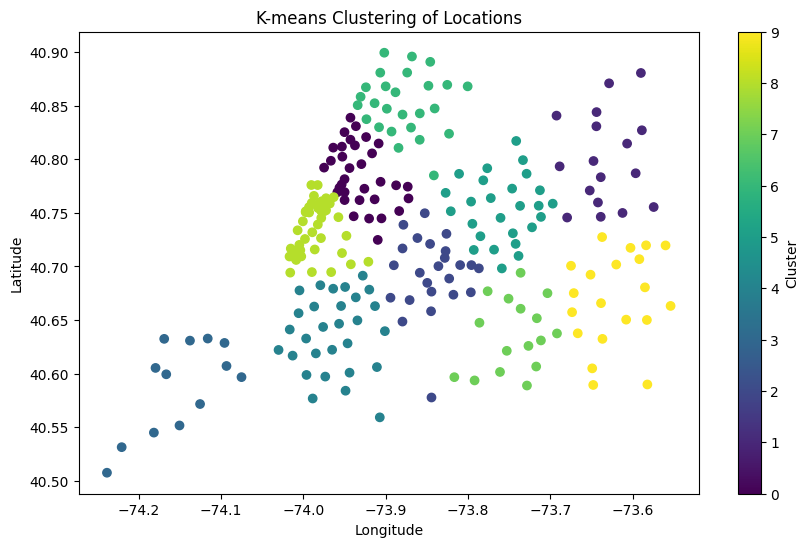

In [15]:
import pandas as pd
from sklearn.cluster import KMeans
import geopandas as gpd
import matplotlib.pyplot as plt

# Assuming 'longitude' and 'latitude' are columns in your cleaned_data.csv
data_path = '/Users/alejandrodiaz/Documents/GitHub/DS_Project/data/processed/cleaned_data.csv'
data = pd.read_csv(data_path)

# Select only the longitude and latitude columns for clustering
location_data = data[['longitude', 'latitude']]

# No need to scale longitude and latitude for geographic clustering

# Determine the number of clusters (you can still use the Elbow Method here)
optimal_k = 10  # for example, after using the Elbow Method
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data['Cluster'] = kmeans.fit_predict(location_data)

# Visualize the clusters
plt.figure(figsize=(10, 6))
plt.scatter(data['longitude'], data['latitude'], c=data['Cluster'], cmap='viridis')
plt.title('K-means Clustering of Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')
plt.show()


/Users/alejandrodiaz/Documents/GitHub/DS_Project/venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



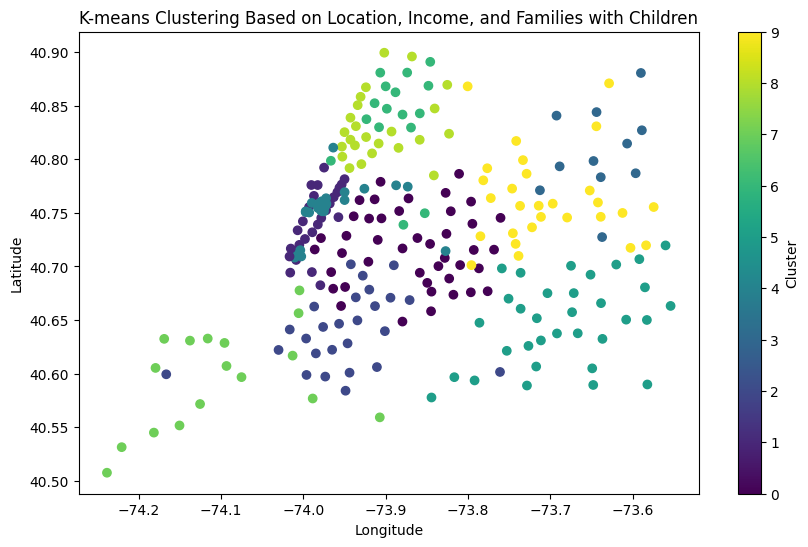

In [18]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load your data
data_path = '/Users/alejandrodiaz/Documents/GitHub/DS_Project/data/processed/cleaned_data.csv'  # Update with the actual path to your dataset
data = pd.read_csv(data_path)

# Select the relevant columns for clustering
columns_to_cluster = ['longitude', 'latitude', 'Median Income of all Families', 'Number of Families with Children']
cluster_data = data[columns_to_cluster]

# Handle any missing values
imputer = SimpleImputer(strategy='median')
cluster_data = imputer.fit_transform(cluster_data)

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(cluster_data)

# Determine the number of clusters (use the Elbow Method or a predetermined number)
optimal_k = 4  # for example
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

# Assign clusters back to the original data
data['Cluster'] = clusters

# Visualize the clusters
plt.figure(figsize=(10, 6))
plt.scatter(data['longitude'], data['latitude'], c=data['Cluster'], cmap='viridis')
plt.title('K-means Clustering Based on Location, Income, and Families with Children')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')
plt.show()


/Users/alejandrodiaz/Documents/GitHub/DS_Project/venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



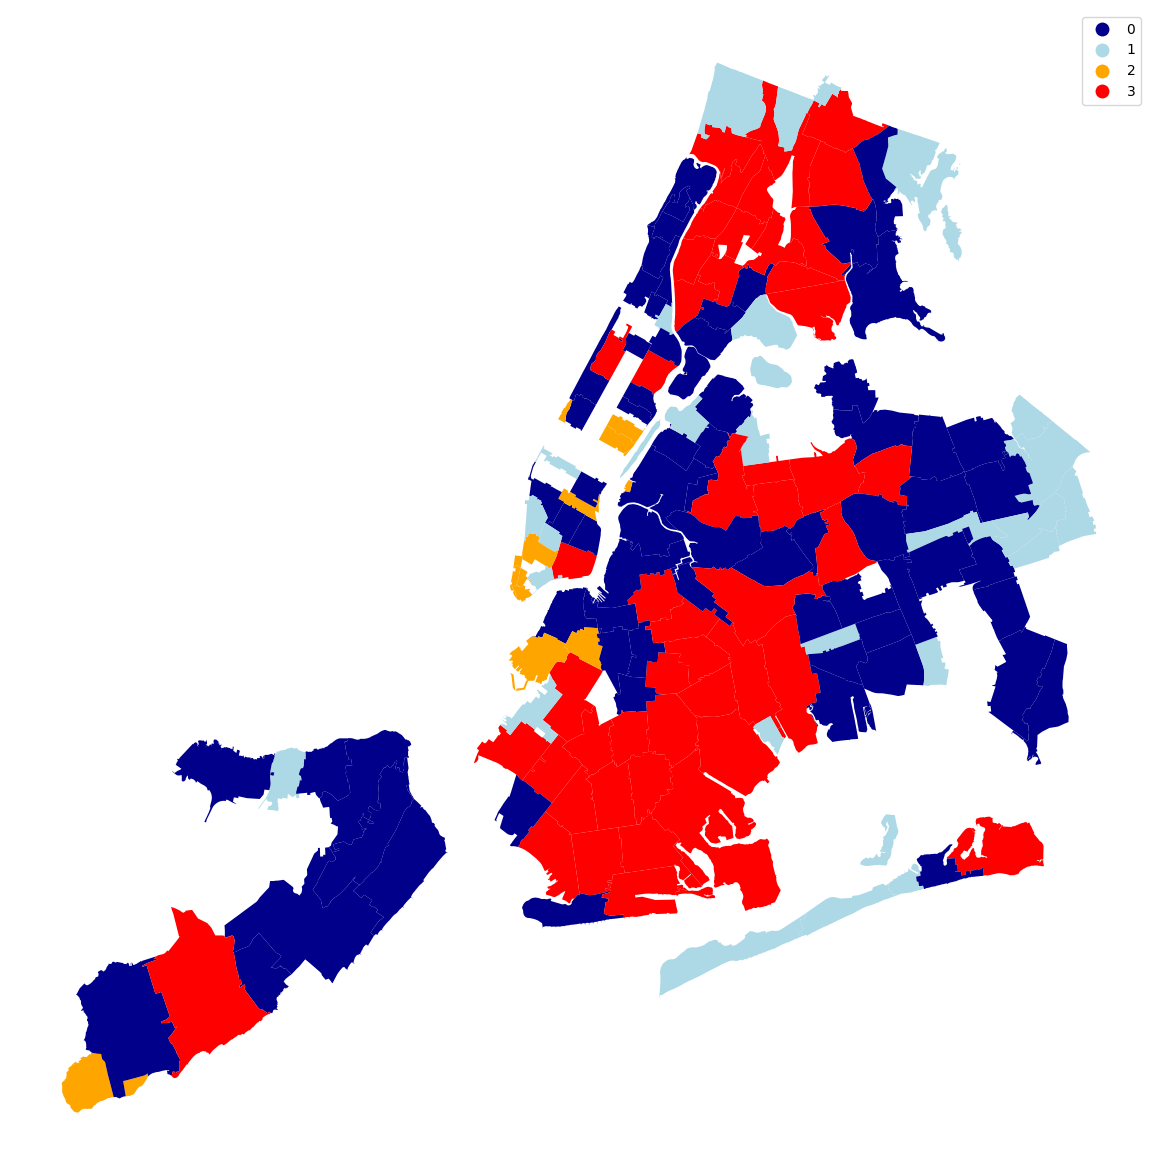

<Figure size 640x480 with 0 Axes>

In [11]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap

# Load your data
data_path = '/Users/alejandrodiaz/Documents/GitHub/DS_Project/data/processed/cleaned_data.csv'
data = pd.read_csv(data_path)

# Convert 'Zip Code' to string
data['Zip Code'] = data['Zip Code'].astype(str)

# Preprocessing and Cleaning
numeric_cols = ['Number of Households', 'Number of Families', 'Number of Families with Children', 
                'Number of Families with NO Children', 'Families with no Earners', 
                'Percent Distribution of Families', 'Percent Distribution of Families with Children', 
                'Percent Distribution of Families with NO Children', 'Median Income of all Households', 
                'Median Income of all Families']
for col in numeric_cols:
    data[col] = pd.to_numeric(data[col], errors='coerce')

imputer = SimpleImputer(strategy='median')
data[numeric_cols] = imputer.fit_transform(data[numeric_cols])

# Scaling the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[numeric_cols])

# Determine the number of clusters (Elbow Method)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data['Cluster'] = kmeans.fit_predict(scaled_features)

# Load the shapefile for ZIP code boundaries
zip_shapes_path = '/Users/alejandrodiaz/Documents/GitHub/DS_Project/data/raw/Modified Zip Code Tabulation Areas (MODZCTA)/geo_export_152003af-efec-4038-9b6f-1963116a24c2.shp'
zip_shapes = gpd.read_file(zip_shapes_path)
zip_shapes['Zip Code'] = zip_shapes['zcta'].astype(str)  # Ensure this column is the correct ZIP code column and convert to string

# Merge clustering results with ZIP code shape data
map_data = zip_shapes.merge(data, left_on='Zip Code', right_on='Zip Code')

# Plotting
fig, ax = plt.subplots(figsize=(15, 15))

# Define the custom color map

# Define the gradient color scheme
colors = ['darkblue', 'lightblue', 'orange', 'red']
cmap = LinearSegmentedColormap.from_list('my_cmap', colors)

# Plot the map with the updated color scheme
map_data.plot(column='Cluster', categorical=True, legend=True, ax=ax, cmap=cmap)

ax.set_axis_off()
plt.show()
cmap = plt.cm.colors.ListedColormap(colors)

# Plot the map with the updated color scheme
map_data.plot(column='Cluster', categorical=True, legend=True, ax=ax, cmap=cmap)

ax.set_axis_off()
plt.show()


In [7]:
import pandas as pd
import plotly.graph_objs as go
from plotly.offline import iplot
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

def load_and_preprocess_data(data_path):
    df = pd.read_csv(data_path)
    df['Median Income of all Families'] = pd.to_numeric(df['Median Income of all Families'], errors='coerce')
    imputer = SimpleImputer(strategy='median')
    df['Median Income of all Families'] = imputer.fit_transform(df[['Median Income of all Families']])
    df.dropna(subset=['longitude', 'latitude', 'Median Income of all Families'], inplace=True)
    df['Scaled_Income'] = df['Median Income of all Families'] / 1000
    return df

def perform_clustering(df):
    if 'Cluster' not in df.columns:
        features = df[['longitude', 'latitude', 'Median Income of all Families']]
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)
        kmeans = KMeans(n_clusters=4, random_state=42)
        df['Cluster'] = kmeans.fit_predict(features_scaled)
    return df

def create_plot(df):
    scaling_factor = df['Median Income of all Families'].max() / 100  # Adjust this value as needed
    df['Scaled_Income'] = df['Median Income of all Families'] / scaling_factor

    data = [
        {
            'x': df["longitude"],
            'y': df["latitude"],
            'text': df.apply(lambda row: f'ZIP: {row["Zip Code"]}<br>Income: ${row["Median Income of all Families"]}', axis=1),
            'mode': 'markers',
            'marker': {
                'color': df["Cluster"],
                'size': df['Scaled_Income'],
                'opacity': 0.5,  # You may want to lower this further
                'showscale': True,
                'colorscale': 'Portland'
            }
        }
    ]

    layout = go.Layout(
        title='New York ZIP Code Clusters (Median Income of all Families)',
        xaxis=dict(title='Longitude', range=[-74.3, -73.8]),
        yaxis=dict(title='Latitude', range=[40.5, 40.9]),
        hovermode='closest'
    )

    fig = go.Figure(data=data, layout=layout)
    iplot(fig)


data_path = '/Users/alejandrodiaz/Documents/GitHub/DS_Project/data/processed/cleaned_data.csv'
df = load_and_preprocess_data(data_path)
df = perform_clustering(df)
create_plot(df)

/Users/alejandrodiaz/Documents/GitHub/DS_Project/venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

